# Classifiers - busy vs relaxed - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

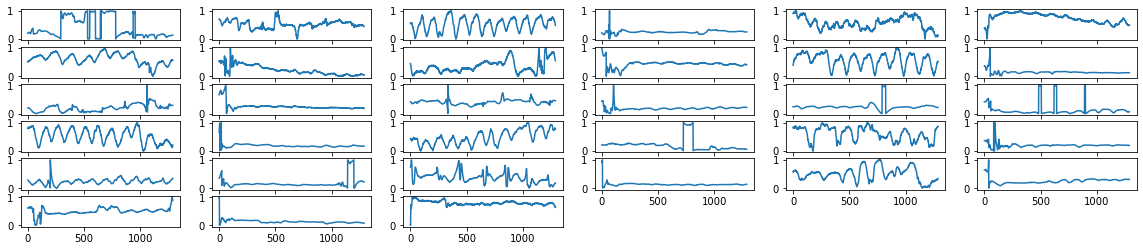

<Figure size 432x288 with 0 Axes>

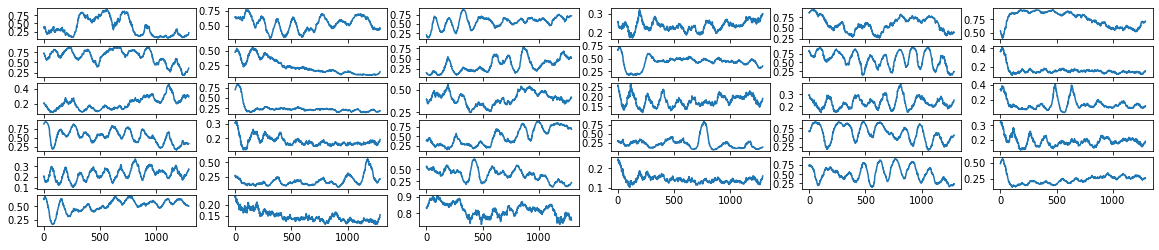

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

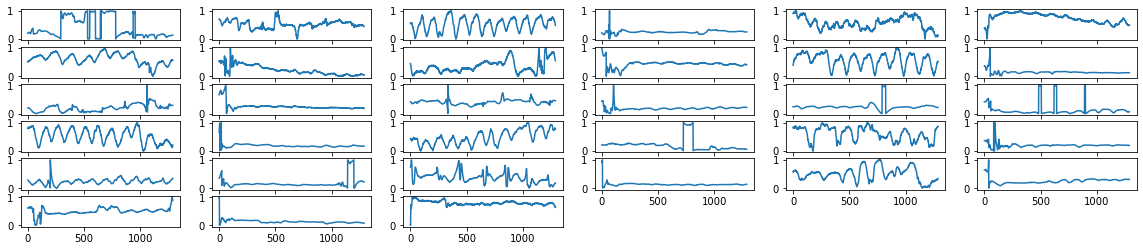

<Figure size 432x288 with 0 Axes>

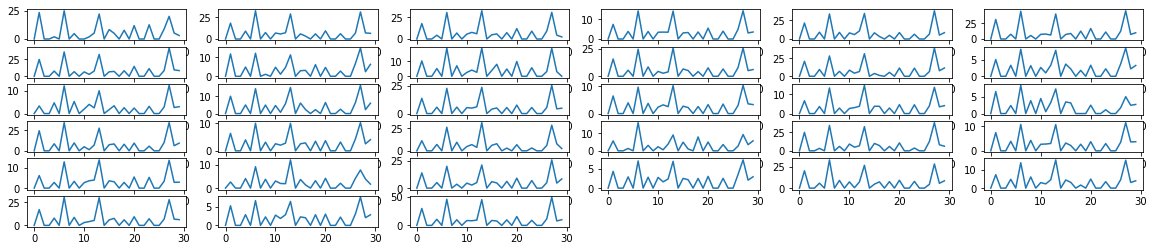

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

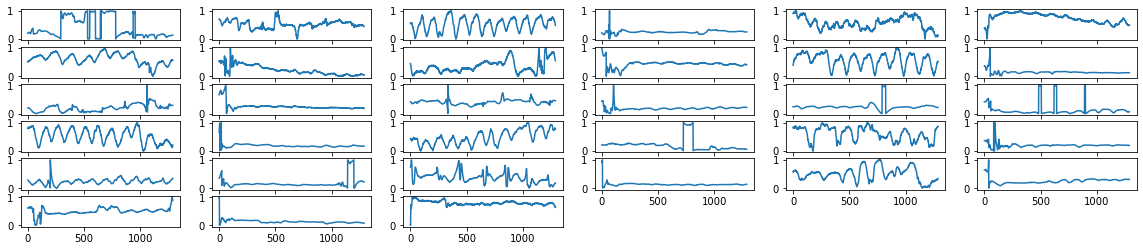

<Figure size 432x288 with 0 Axes>

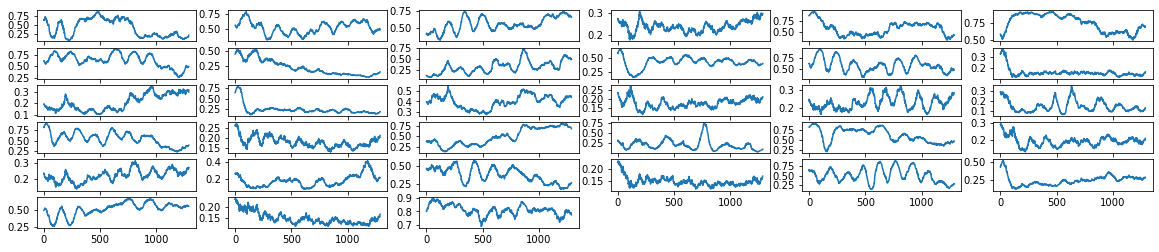

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

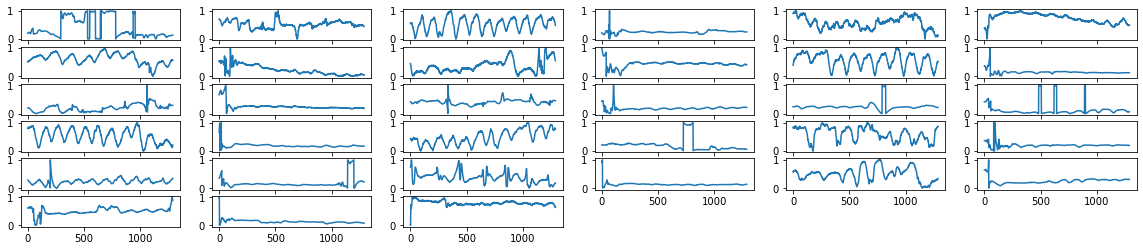

<Figure size 432x288 with 0 Axes>

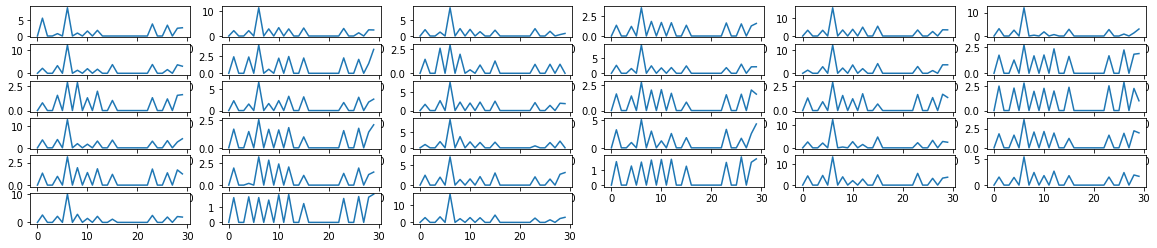

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

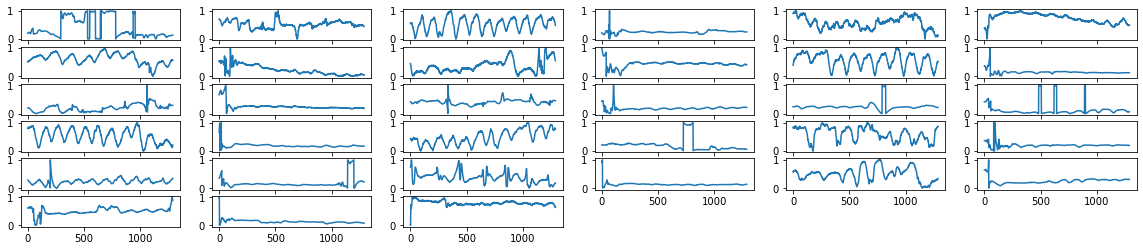

<Figure size 432x288 with 0 Axes>

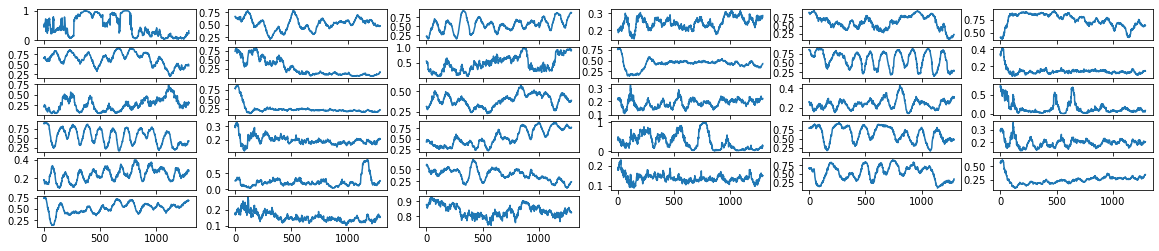

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

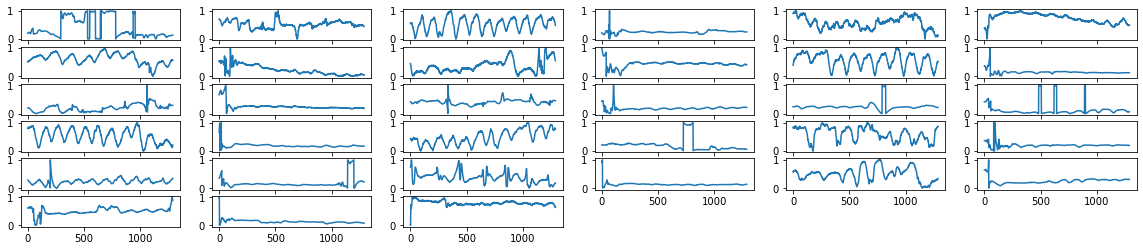

<Figure size 432x288 with 0 Axes>

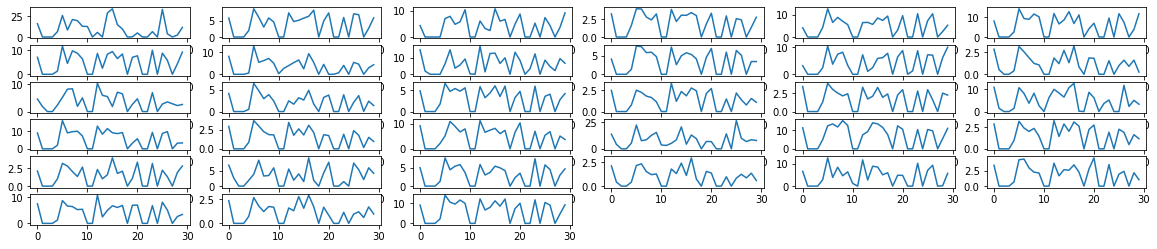

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [33]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [34]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [35]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [36]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:29.060332
iteration: 3 of 23 ; time elapsed: 0:00:56.319146
iteration: 4 of 23 ; time elapsed: 0:01:24.120175
iteration: 5 of 23 ; time elapsed: 0:01:52.279956
iteration: 6 of 23 ; time elapsed: 0:02:19.010783
iteration: 7 of 23 ; time elapsed: 0:02:46.809732
iteration: 8 of 23 ; time elapsed: 0:03:13.938323
iteration: 9 of 23 ; time elapsed: 0:03:40.586842
iteration: 10 of 23 ; time elapsed: 0:04:07.243745
iteration: 11 of 23 ; time elapsed: 0:04:33.970909
iteration: 12 of 23 ; time elapsed: 0:05:01.027686
iteration: 13 of 23 ; time elapsed: 0:05:28.622637
iteration: 14 of 23 ; time elapsed: 0:05:56.825638
iteration: 15 of 23 ; time elapsed: 0:06:24.577846
iteration: 16 of 23 ; time elapsed: 0:06:51.666077
iteration: 17 of 23 ; time elapsed: 0:07:18.686478
iteration: 18 of 23 ; time elapsed: 0:07:46.861654
iteration: 19 of 23 ; time elapsed: 0:08:14.521737
iteration: 20 of 23 ; time elapsed: 0:08:42.437

In [37]:
accuracies['simple_dense'] = accs

In [38]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.583333,0.625000,0.625000,0.583333,0.666667,0.666667,62i9y
1,0.852941,0.764706,0.558824,0.676471,0.676471,0.617647,0.470588,2gu87
2,0.666667,0.805556,0.388889,0.777778,0.777778,0.722222,0.472222,iz2ps
3,0.470588,0.676471,0.617647,0.588235,0.500000,0.529412,0.500000,1mpau
4,0.633333,0.700000,0.666667,0.566667,0.666667,0.566667,0.533333,7dwjy
5,0.656250,0.781250,0.437500,0.906250,0.625000,0.812500,0.625000,7swyk
6,0.625000,0.562500,0.593750,0.625000,0.687500,0.593750,0.593750,94mnx
7,0.566667,0.466667,0.600000,0.600000,0.566667,0.600000,0.533333,bd47a
8,0.533333,0.866667,0.633333,0.866667,0.566667,0.766667,0.466667,c24ur
9,0.666667,0.766667,0.600000,0.700000,0.633333,0.633333,0.633333,ctsax


In [39]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.400000   0.466667   0.388889        0.312500       0.437500  0.333333  0.400000
max     0.852941   0.866667   0.750000        0.906250       0.777778  0.812500  0.781250
mean    0.599529   0.675627   0.543111        0.655877       0.607442  0.643999  0.566029
median  0.617647   0.687500   0.558824        0.625000       0.593750  0.647059  0.555556


#### LSTM-based classifier  
based on the original author's code

In [40]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [41]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [42]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [43]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [44]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:24.972427
iteration: 3 of 23 ; time elapsed: 0:02:42.321001
iteration: 4 of 23 ; time elapsed: 0:03:59.676066
iteration: 5 of 23 ; time elapsed: 0:05:20.993463
iteration: 6 of 23 ; time elapsed: 0:06:41.686994
iteration: 7 of 23 ; time elapsed: 0:08:06.947342
iteration: 8 of 23 ; time elapsed: 0:09:33.917355
iteration: 9 of 23 ; time elapsed: 0:11:01.449994
iteration: 10 of 23 ; time elapsed: 0:12:26.216810
iteration: 11 of 23 ; time elapsed: 0:13:51.575145
iteration: 12 of 23 ; time elapsed: 0:15:20.042928
iteration: 13 of 23 ; time elapsed: 0:16:44.145407
iteration: 14 of 23 ; time elapsed: 0:18:10.951125
iteration: 15 of 23 ; time elapsed: 0:19:35.694236
iteration: 16 of 23 ; time elapsed: 0:21:01.720759
iteration: 17 of 23 ; time elapsed: 0:22:26.191328
iteration: 18 of 23 ; time elapsed: 0:23:49.212485
iteration: 19 of 23 ; time elapsed: 0:25:14.238079
iteration: 20 of 23 ; time elapsed: 0:26:38.899

In [45]:
accuracies['LSTM'] = accs

In [46]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.708333,0.541667,0.500000,0.583333,0.541667,0.625000,0.666667,62i9y
1,0.794118,0.735294,0.617647,0.705882,0.735294,0.617647,0.441176,2gu87
2,0.972222,0.861111,0.527778,0.861111,0.750000,0.694444,0.527778,iz2ps
3,0.617647,0.617647,0.529412,0.588235,0.558824,0.529412,0.470588,1mpau
4,0.733333,0.666667,0.666667,0.600000,0.433333,0.533333,0.466667,7dwjy
5,0.687500,0.750000,0.500000,0.781250,0.656250,0.718750,0.687500,7swyk
6,0.750000,0.531250,0.468750,0.531250,0.656250,0.562500,0.593750,94mnx
7,0.833333,0.633333,0.533333,0.533333,0.500000,0.600000,0.633333,bd47a
8,0.566667,0.566667,0.633333,0.666667,0.533333,0.433333,0.466667,c24ur
9,0.766667,0.833333,0.466667,0.833333,0.633333,0.566667,0.700000,ctsax


In [47]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.433333   0.437500   0.312500        0.416667       0.433333  0.343750  0.441176
max     0.972222   0.941176   0.666667        0.861111       0.750000  0.718750  0.882353
mean    0.652334   0.650927   0.499062        0.629634       0.573160  0.577597  0.582777
median  0.676471   0.633333   0.500000        0.617647       0.558824  0.583333  0.583333


#### kNN

In [48]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [49]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [50]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [52]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.125662
iteration: 3 of 23 ; time elapsed: 0:00:00.219440
iteration: 4 of 23 ; time elapsed: 0:00:00.307177
iteration: 5 of 23 ; time elapsed: 0:00:00.402950
iteration: 6 of 23 ; time elapsed: 0:00:00.496669
iteration: 7 of 23 ; time elapsed: 0:00:00.592413
iteration: 8 of 23 ; time elapsed: 0:00:00.682173
iteration: 9 of 23 ; time elapsed: 0:00:00.773957
iteration: 10 of 23 ; time elapsed: 0:00:00.876654
iteration: 11 of 23 ; time elapsed: 0:00:00.969405
iteration: 12 of 23 ; time elapsed: 0:00:01.060192
iteration: 13 of 23 ; time elapsed: 0:00:01.148953
iteration: 14 of 23 ; time elapsed: 0:00:01.239682
iteration: 15 of 23 ; time elapsed: 0:00:01.327447
iteration: 16 of 23 ; time elapsed: 0:00:01.418206
iteration: 17 of 23 ; time elapsed: 0:00:01.510956
iteration: 18 of 23 ; time elapsed: 0:00:01.603710
iteration: 19 of 23 ; time elapsed: 0:00:01.701448
iteration: 20 of 23 ; time elapsed: 0:00:01.793

In [54]:
accuracies['kNN'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.416667,0.500000,0.625000,0.375000,0.625000,0.708333,0.583333,62i9y
1,0.735294,0.676471,0.529412,0.735294,0.470588,0.558824,0.470588,2gu87
2,0.611111,0.944444,0.500000,0.916667,0.666667,0.694444,0.722222,iz2ps
3,0.764706,0.558824,0.500000,0.558824,0.470588,0.500000,0.529412,1mpau
4,0.800000,0.633333,0.666667,0.600000,0.600000,0.633333,0.566667,7dwjy
5,0.750000,0.812500,0.531250,0.750000,0.625000,0.812500,0.781250,7swyk
6,0.718750,0.593750,0.500000,0.656250,0.531250,0.593750,0.687500,94mnx
7,0.700000,0.700000,0.566667,0.700000,0.600000,0.666667,0.633333,bd47a
8,0.466667,0.766667,0.600000,0.766667,0.600000,0.433333,0.433333,c24ur
9,0.733333,0.866667,0.700000,0.833333,0.633333,0.700000,0.700000,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.416667   0.500000   0.352941        0.375000       0.444444  0.406250  0.433333
max     0.800000   0.944444   0.700000        0.916667       0.666667  0.852941  0.781250
mean    0.630818   0.694190   0.530483        0.643936       0.579508  0.629962  0.598991
median  0.625000   0.687500   0.531250        0.625000       0.600000  0.633333  0.593750


####  SVC

In [57]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [58]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [59]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [60]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [61]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [62]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.807840
iteration: 3 of 23 ; time elapsed: 0:00:01.578806
iteration: 4 of 23 ; time elapsed: 0:00:02.340739
iteration: 5 of 23 ; time elapsed: 0:00:03.097741
iteration: 6 of 23 ; time elapsed: 0:00:03.857681
iteration: 7 of 23 ; time elapsed: 0:00:04.625626
iteration: 8 of 23 ; time elapsed: 0:00:05.383627
iteration: 9 of 23 ; time elapsed: 0:00:06.163546
iteration: 10 of 23 ; time elapsed: 0:00:06.952433
iteration: 11 of 23 ; time elapsed: 0:00:07.716358
iteration: 12 of 23 ; time elapsed: 0:00:08.478352
iteration: 13 of 23 ; time elapsed: 0:00:09.229312
iteration: 14 of 23 ; time elapsed: 0:00:09.988310
iteration: 15 of 23 ; time elapsed: 0:00:10.765231
iteration: 16 of 23 ; time elapsed: 0:00:11.530184
iteration: 17 of 23 ; time elapsed: 0:00:12.300097
iteration: 18 of 23 ; time elapsed: 0:00:13.092975
iteration: 19 of 23 ; time elapsed: 0:00:13.857957
iteration: 20 of 23 ; time elapsed: 0:00:14.741

In [63]:
accuracies['SVC'] = accs

In [64]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.666667,0.500000,0.625000,0.541667,0.583333,0.666667,0.541667,62i9y
1,0.647059,0.764706,0.529412,0.647059,0.735294,0.617647,0.470588,2gu87
2,0.750000,0.888889,0.472222,0.916667,0.888889,0.722222,0.555556,iz2ps
3,0.558824,0.617647,0.676471,0.676471,0.470588,0.500000,0.470588,1mpau
4,0.666667,0.700000,0.666667,0.633333,0.500000,0.566667,0.533333,7dwjy
5,0.687500,0.812500,0.343750,0.781250,0.531250,0.687500,0.625000,7swyk
6,0.625000,0.593750,0.593750,0.562500,0.718750,0.625000,0.593750,94mnx
7,0.533333,0.600000,0.633333,0.600000,0.533333,0.566667,0.600000,bd47a
8,0.600000,0.800000,0.666667,0.800000,0.666667,0.500000,0.466667,c24ur
9,0.700000,0.833333,0.700000,0.800000,0.666667,0.566667,0.600000,ctsax


In [65]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.375000   0.500000   0.300000        0.468750       0.437500  0.433333  0.400000
max     0.750000   0.888889   0.700000        0.916667       0.888889  0.750000  0.687500
mean    0.612727   0.678254   0.523549        0.666743       0.592675  0.611802  0.548092
median  0.617647   0.656250   0.529412        0.647059       0.588235  0.625000  0.558824


#### Random Forest

In [66]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [67]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [68]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [69]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [70]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:04.182470
iteration: 3 of 23 ; time elapsed: 0:00:08.151240
iteration: 4 of 23 ; time elapsed: 0:00:11.905993
iteration: 5 of 23 ; time elapsed: 0:00:15.461449
iteration: 6 of 23 ; time elapsed: 0:00:19.051698
iteration: 7 of 23 ; time elapsed: 0:00:22.603000
iteration: 8 of 23 ; time elapsed: 0:00:26.533782
iteration: 9 of 23 ; time elapsed: 0:00:30.984386
iteration: 10 of 23 ; time elapsed: 0:00:35.022982
iteration: 11 of 23 ; time elapsed: 0:00:38.886349
iteration: 12 of 23 ; time elapsed: 0:00:42.730125
iteration: 13 of 23 ; time elapsed: 0:00:46.612675
iteration: 14 of 23 ; time elapsed: 0:00:50.379664
iteration: 15 of 23 ; time elapsed: 0:00:54.203577
iteration: 16 of 23 ; time elapsed: 0:00:58.016545
iteration: 17 of 23 ; time elapsed: 0:01:01.923673
iteration: 18 of 23 ; time elapsed: 0:01:05.883524
iteration: 19 of 23 ; time elapsed: 0:01:09.534870
iteration: 20 of 23 ; time elapsed: 0:01:13.284

In [72]:
accuracies['random_forest'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.750000,0.666667,0.416667,0.500000,0.708333,0.708333,0.708333,62i9y
1,0.588235,0.735294,0.588235,0.705882,0.676471,0.676471,0.617647,2gu87
2,0.750000,0.861111,0.527778,0.888889,0.833333,0.916667,0.694444,iz2ps
3,0.647059,0.705882,0.558824,0.676471,0.558824,0.617647,0.617647,1mpau
4,0.566667,0.633333,0.600000,0.666667,0.500000,0.566667,0.566667,7dwjy
5,0.750000,0.781250,0.437500,0.812500,0.625000,0.750000,0.656250,7swyk
6,0.625000,0.625000,0.562500,0.656250,0.531250,0.468750,0.500000,94mnx
7,0.633333,0.600000,0.466667,0.633333,0.566667,0.533333,0.633333,bd47a
8,0.666667,0.833333,0.533333,0.866667,0.566667,0.466667,0.633333,c24ur
9,0.700000,0.900000,0.600000,0.800000,0.666667,0.766667,0.766667,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.531250   0.468750   0.352941        0.406250       0.472222  0.466667  0.406250
max     0.823529   0.900000   0.625000        0.888889       0.833333  0.916667  0.766667
mean    0.656694   0.699488   0.506250        0.685910       0.596089  0.636756  0.596512
median  0.647059   0.700000   0.527778        0.676471       0.566667  0.676471  0.593750


#### Naive Bayesian

In [75]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [76]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [77]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.086766
iteration: 3 of 23 ; time elapsed: 0:00:00.175531
iteration: 4 of 23 ; time elapsed: 0:00:00.263296
iteration: 5 of 23 ; time elapsed: 0:00:00.345076
iteration: 6 of 23 ; time elapsed: 0:00:00.423374
iteration: 7 of 23 ; time elapsed: 0:00:00.505665
iteration: 8 of 23 ; time elapsed: 0:00:00.582771
iteration: 9 of 23 ; time elapsed: 0:00:00.667579
iteration: 10 of 23 ; time elapsed: 0:00:00.764914
iteration: 11 of 23 ; time elapsed: 0:00:00.848714
iteration: 12 of 23 ; time elapsed: 0:00:00.932466
iteration: 13 of 23 ; time elapsed: 0:00:01.012282
iteration: 14 of 23 ; time elapsed: 0:00:01.094859
iteration: 15 of 23 ; time elapsed: 0:00:01.191600
iteration: 16 of 23 ; time elapsed: 0:00:01.274377
iteration: 17 of 23 ; time elapsed: 0:00:01.366131
iteration: 18 of 23 ; time elapsed: 0:00:01.445946
iteration: 19 of 23 ; time elapsed: 0:00:01.529694
iteration: 20 of 23 ; time elapsed: 0:00:01.627

In [78]:
accuracies['naive_bayesian'] = accs

In [79]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.666667,0.333333,0.375000,0.375000,0.500000,0.666667,0.625000,62i9y
1,0.411765,0.735294,0.294118,0.588235,0.470588,0.617647,0.529412,2gu87
2,0.500000,0.944444,0.527778,0.888889,0.361111,0.611111,0.472222,iz2ps
3,0.558824,0.558824,0.441176,0.529412,0.500000,0.441176,0.500000,1mpau
4,0.466667,0.533333,0.233333,0.500000,0.433333,0.533333,0.533333,7dwjy
5,0.656250,0.781250,0.562500,0.781250,0.531250,0.531250,0.656250,7swyk
6,0.593750,0.562500,0.531250,0.562500,0.437500,0.593750,0.531250,94mnx
7,0.566667,0.666667,0.633333,0.666667,0.466667,0.600000,0.633333,bd47a
8,0.466667,0.566667,0.666667,0.566667,0.433333,0.466667,0.466667,c24ur
9,0.633333,0.933333,0.500000,0.900000,0.433333,0.500000,0.666667,ctsax


In [80]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.411765   0.333333   0.233333        0.375000       0.323529  0.437500  0.382353
max     0.687500   0.944444   0.687500        0.900000       0.588235  0.722222  0.666667
mean    0.528009   0.630190   0.522119        0.611333       0.466624  0.558783  0.530717
median  0.500000   0.647059   0.531250        0.566667       0.470588  0.562500  0.529412


#### XGBoost

In [81]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [82]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [83]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [84]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [85]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [86]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:04.233825
iteration: 3 of 23 ; time elapsed: 0:00:06.193077
iteration: 4 of 23 ; time elapsed: 0:00:08.139249
iteration: 5 of 23 ; time elapsed: 0:00:10.130924
iteration: 6 of 23 ; time elapsed: 0:00:12.198805
iteration: 7 of 23 ; time elapsed: 0:00:14.285804
iteration: 8 of 23 ; time elapsed: 0:00:16.248684
iteration: 9 of 23 ; time elapsed: 0:00:18.308392
iteration: 10 of 23 ; time elapsed: 0:00:20.393395
iteration: 11 of 23 ; time elapsed: 0:00:22.570526
iteration: 12 of 23 ; time elapsed: 0:00:24.679368
iteration: 13 of 23 ; time elapsed: 0:00:26.699045
iteration: 14 of 23 ; time elapsed: 0:00:28.895936
iteration: 15 of 23 ; time elapsed: 0:00:30.934781
iteration: 16 of 23 ; time elapsed: 0:00:32.997843
iteration: 17 of 23 ; time elapsed: 0:00:35.084195
iteration: 18 of 23 ; time elapsed: 0:00:37.254837
iteration: 19 of 23 ; time elapsed: 0:00:39.260550
iteration: 20 of 23 ; time elapsed: 0:00:41.255

In [87]:
accuracies['XGBoost'] = accs

In [88]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.583333,0.583333,0.458333,0.541667,0.708333,0.666667,0.708333,62i9y
1,0.617647,0.735294,0.470588,0.705882,0.676471,0.588235,0.588235,2gu87
2,0.638889,0.888889,0.527778,0.833333,0.694444,0.805556,0.722222,iz2ps
3,0.676471,0.617647,0.588235,0.647059,0.558824,0.676471,0.529412,1mpau
4,0.633333,0.633333,0.600000,0.600000,0.500000,0.600000,0.566667,7dwjy
5,0.781250,0.656250,0.437500,0.781250,0.718750,0.593750,0.531250,7swyk
6,0.531250,0.593750,0.468750,0.593750,0.531250,0.500000,0.468750,94mnx
7,0.600000,0.533333,0.433333,0.566667,0.566667,0.566667,0.566667,bd47a
8,0.666667,0.866667,0.500000,0.866667,0.566667,0.533333,0.566667,c24ur
9,0.733333,0.766667,0.633333,0.833333,0.666667,0.666667,0.600000,ctsax


In [89]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.437500   0.437500   0.406250        0.343750       0.472222  0.500000  0.444444
max     0.794118   0.888889   0.633333        0.866667       0.718750  0.805556  0.722222
mean    0.634925   0.674616   0.514246        0.676551       0.602259  0.605953  0.570943
median  0.638889   0.656250   0.500000        0.676471       0.593750  0.593750  0.566667


###  Compare Accuracies

Save all accuracies to results csv file:

In [94]:
results_path = "results/BvR/BvR-all.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [95]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.400000   0.466667   0.388889        0.312500       0.437500  0.333333  0.400000
max     0.852941   0.866667   0.750000        0.906250       0.777778  0.812500  0.781250
mean    0.599529   0.675627   0.543111        0.655877       0.607442  0.643999  0.566029
median  0.617647   0.687500   0.558824        0.625000       0.593750  0.647059  0.555556


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.433333   0.437500   0.312500        0.416667       0.433333  0.343750  0.441176
max     0.972222   0.941176   0.666667        0.861111       0.750000  0.718750  0.882353
mean    0.652334   0.650927   0.499062        0.629634       0.573160  0.577597  0.582777
median  0.676471   0.633333   0.500000        0.617647       0.558824  0.583333  0.583333


----------- kNN: -----------

Print all accuracies in table form:

In [96]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.500000   0.583333   0.625000        0.625000       0.583333  0.666667  0.666667   62i9y
1   0.852941   0.764706   0.558824        0.676471       0.676471  0.617647  0.470588   2gu87
2   0.666667   0.805556   0.388889        0.777778       0.777778  0.722222  0.472222   iz2ps
3   0.470588   0.676471   0.617647        0.588235       0.500000  0.529412  0.500000   1mpau
4   0.633333   0.700000   0.666667        0.566667       0.666667  0.566667  0.533333   7dwjy
5   0.656250   0.781250   0.437500        0.906250       0.625000  0.812500  0.625000   7swyk
6   0.625000   0.562500   0.593750        0.625000       0.687500  0.593750  0.593750   94mnx
7   0.566667   0.466667   0.600000        0.600000       0.566667  0.600000  0.533333   bd47a
8   0.533333   0.866667   0.633333        0.866667       0.566667  0.766667  0.466667   c24ur
9   0.666667   0.766667   0.600000        0.70